## Spam detection system w URL (exploration)

In [104]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pickle import dump

In [2]:
# load data
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [3]:
df_raw.sample(10, random_state=2025)

,url,is_spam
1897,https://briefingday.com/fan,True
98,https://seattle.eater.com/2020/6/18/21293916/s...,False
141,https://www.buzzfeednews.com/article/tanyachen...,False
2128,https://www.nytimes.com/2020/06/29/movies/sund...,False
2953,http://gettheelevator.com/editorial,True
2537,https://www.theverge.com/2020/6/29/21304947/re...,False
1801,https://www.earios.net/,False
1024,https://old.reddit.com/r/AskReddit/comments/he...,False
37,https://www.theobservereffect.org/marc.html,False
4,https://briefingday.com/fan,True


In [ ]:
# Preprocessing
df_baking = df_raw.copy()

df_baking['url'] = df_baking['url'].str.lower()
df_baking['url'] = df_baking['url'].str.strip()
df_baking['url'] = df_baking['url'].str.replace('http://', '')
df_baking['url'] = df_baking['url'].str.replace('https://', '')
df_baking['url'] = df_baking['url'].str.replace('www.', '')
df_baking['url'] = df_baking['url'].str.replace('.com', '')
df_baking['url'] = df_baking['url'].str.replace('-', ' ')
df_baking['url'] = df_baking['url'].str.replace('/', ' ')
df_baking['url'] = df_baking['url'].str.replace('.', ' ')
df_baking['url'] = df_baking['url'].str.replace('&lt;#&gt;', ',')

df_baking = df_baking.drop_duplicates()


df = df_baking.copy()
df.sample(10, random_state=2025)

,url,is_spam
1897,briefingday fan,True
98,seattle eater 2020 6 18 21293916 seattle prote...,False
141,buzzfeednews article tanyachen influencers its...,False
2128,nytimes 2020 06 29 movies sundance virus html,False
2953,gettheelevator editorial,True
2537,theverge 2020 6 29 21304947 reddit ban subredd...,False
1801,earios net,False
1024,old reddit r AskReddit comments hep0l9 what_is...,False
37,theobservereffect org marc html,False
4,briefingday fan,True


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['is_spam'], random_state=2025)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_test.shape

((2399, 2), (600, 2))

In [6]:
df_train.describe().T

,count,unique,top,freq
url,2399,1931,bloomberg tosv2 html,23
is_spam,2399,2,False,1842


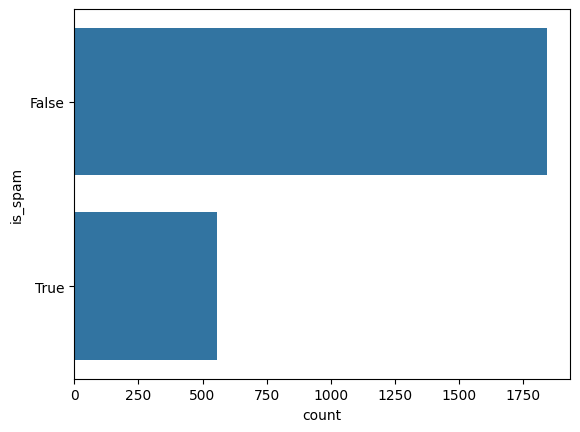

In [7]:
sns.countplot(df_train, y='is_spam')
plt.show()

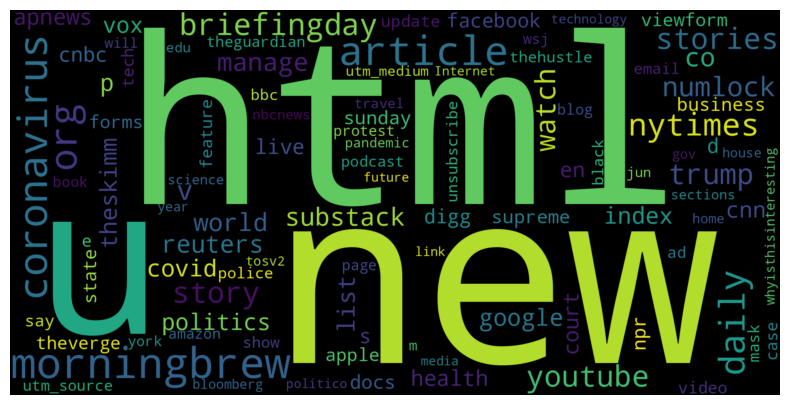

In [23]:
# Most popular words in the url
wc = WordCloud(
    width=2000,
    height=1000,
    max_words=100,
    background_color='black',
    collocations=False, 
).generate(' '.join(df_train['url']))

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

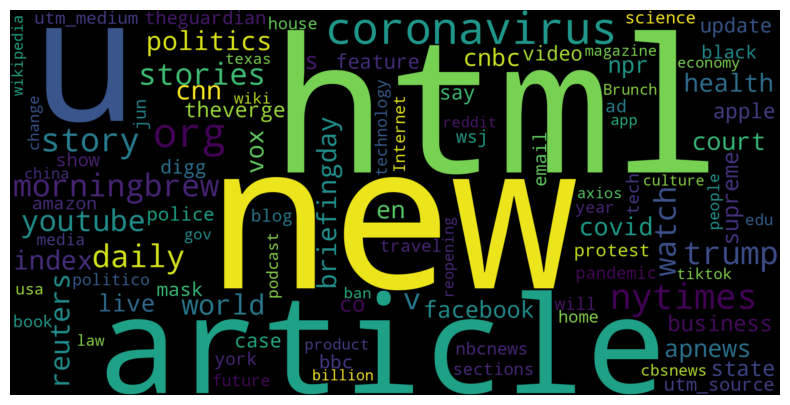

In [24]:
# Most popular words not_spam
wc_spam = WordCloud(
    width=2000,
    height=1000,
    max_words=100,
    background_color='black',
    collocations=False
).generate(' '.join(df_train[df_train['is_spam'] == False]['url']))

plt.figure(figsize=(10, 5))
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

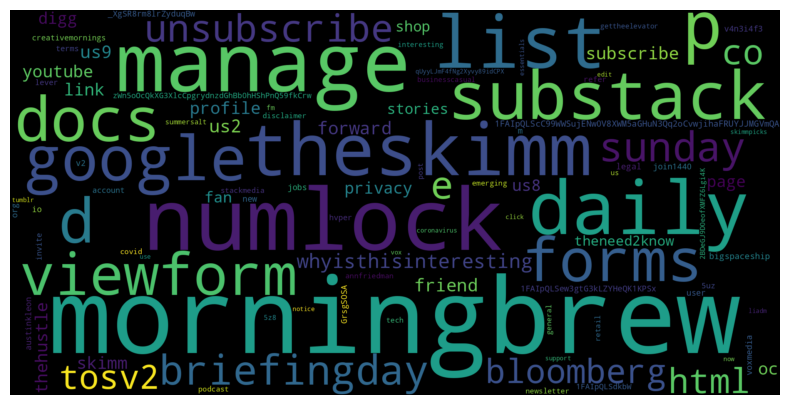

In [21]:
# Most popular words spam
wc_spam = WordCloud(
    width=2000,
    height=1000,
    max_words=100,
    background_color='black',
    collocations=False
).generate(' '.join(df_train[df_train['is_spam'] == True]['url']))

plt.figure(figsize=(10, 5))
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.show()

### Build SVC model

In [30]:
# Machine learning
tokens_X_train = df_train['url']
y_train = df_train['is_spam']

tokens_X_test = df_test['url']
y_test = df_test['is_spam']

tokens_X_train = tokens_X_train.reset_index(drop=True)
tokens_X_test = tokens_X_test.reset_index(drop=True)

In [32]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(tokens_X_train)
X_test = vectorizer.transform(tokens_X_test)

In [98]:
model_svc = SVC(kernel='linear', random_state=2025, class_weight='balanced')
model_svc.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [99]:
y_hat = model_svc.predict(X_test)

In [44]:
def display_metrics(y_hat, y_test):
    print(f'Accuracy score: {accuracy_score(y_hat, y_test)}')
    print(classification_report(y_hat, y_test))

    cm = confusion_matrix(y_hat, y_test, labels=[True, False])
    disp = ConfusionMatrixDisplay(cm, display_labels=['spam', 'not_spam'])

    disp.plot()
    plt.show()

Accuracy score: 0.975
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       462
        True       0.94      0.95      0.95       138

    accuracy                           0.97       600
   macro avg       0.96      0.97      0.96       600
weighted avg       0.98      0.97      0.98       600



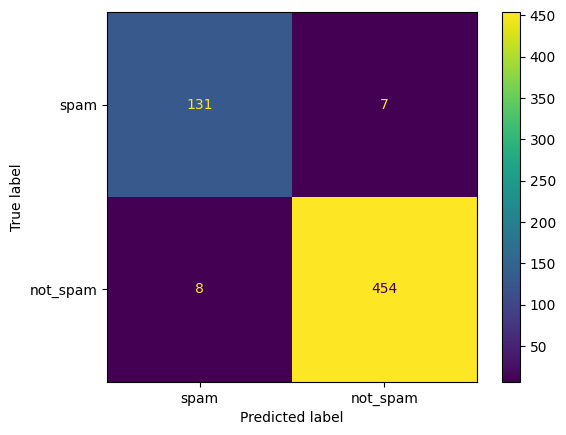

In [45]:
display_metrics(y_hat, y_test)

scipy.sparse._csr.csr_matrix

A grid search could be performed to optimize the previous model, although, for the sake of discussion (and to personally reinforce certain topics) a neural network will be trained.

In [100]:
# Deep learning
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_array.shape[1], )),
    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_nn.summary()

/workspaces/spam-detection-system/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall')])

history = model_nn.fit(
    X_train_array, y_train,
    epochs=15, batch_size=128,
    validation_split=0.2
  )

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7389 - loss: 0.6611 - precision: 0.2842 - recall: 0.0587 - val_accuracy: 0.7979 - val_loss: 0.6059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7603 - loss: 0.5393 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7979 - val_loss: 0.4437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7926 - loss: 0.3710 - precision: 1.0000 - recall: 0.1348 - val_accuracy: 0.8750 - val_loss: 0.2945 - val_precision: 1.0000 - val_recall: 0.3814
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9125 - loss: 0.2364 - precision: 0.9966 - recall: 0.6370 - val_accuracy: 0.9500 - val_loss: 0.2020 - val_precision: 1.0000 - val_recall: 0.7526
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9687 - loss: 0.1338 - precision: 0.9808 - recall: 0.8870 - val_accuracy: 0.

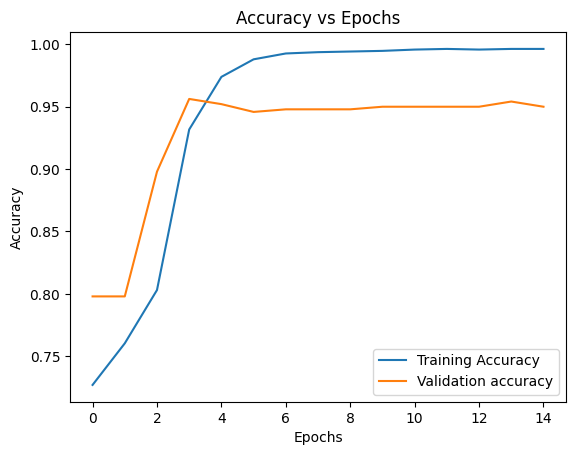

In [94]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()

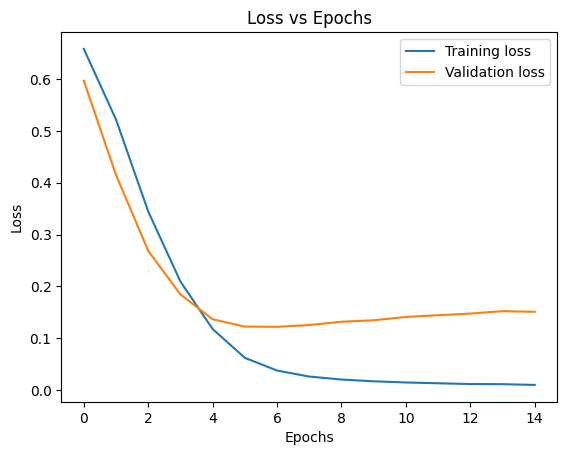

In [95]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs Epochs')
plt.legend()

plt.show()

In [102]:
model_nn.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9600 - loss: 0.1660 - precision: 0.9389 - recall: 0.8849  


[0.16600647568702698,
 0.9599999785423279,
 0.9389312863349915,
 0.8848921060562134]

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy score: 0.96
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       469
           1       0.88      0.94      0.91       131

    accuracy                           0.96       600
   macro avg       0.93      0.95      0.94       600
weighted avg       0.96      0.96      0.96       600



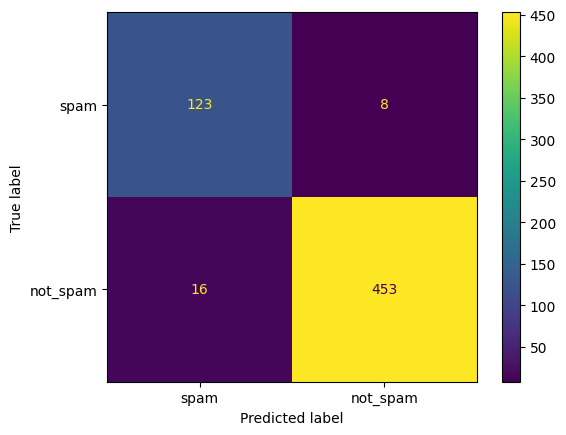

In [103]:
y_hat_nn = (model_nn.predict(X_test) > 0.5).astype("int32")

display_metrics(y_hat_nn, y_test)

The neural network has fewer accuracy and recall than the SVC model. It still performs quite decently by having F1 scores over 0.9, although, precission for the not_spam class is a little low. This can be dangerous since it means more emails are being cataloged as spam when in reality they shouldn't be classified as so. 

In [105]:
# Save models
dump(model_svc, open('../models/svc_model.sav', 'wb'))
model_nn.save("../models/neural_network_model.keras")